<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/tf2/tf-low-level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Neural Networks with Low Level TensorFlow 2

Based on 
* This thread is a crash course on everything you need to know to use TensorFlow 2.0 + Keras for deep learning research: https://twitter.com/fchollet/status/1105139360226140160
* Colab Notebook _tf.keras for Researchers_: https://colab.research.google.com/drive/17u-pRZJnKN0gO5XZmq8n5A2bKGrfKEUg#scrollTo=UHOOlixcQ9Gl
* Effective TensorFlow 2: https://www.tensorflow.org/alpha/guide/effective_tf2


In [1]:
!pip install -q tf-nightly-gpu-2.0-preview

    100% |████████████████████████████████| 345.7MB 62kB/s 
    100% |████████████████████████████████| 3.1MB 8.4MB/s 
    100% |████████████████████████████████| 61kB 22.6MB/s 
    100% |████████████████████████████████| 430kB 7.6MB/s 
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-dev20190423


In [3]:
# a small sanity check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print("This works: {}".format(hello))

This works: b'Hello TF!'


In [4]:
# this should return True even on Colab
tf.test.is_gpu_available()

True

In [7]:
tf.test.is_built_with_cuda()

True

In [8]:
!nvidia-smi

Wed Apr 24 07:10:10 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    71W / 149W |     71MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [9]:
tf.executing_eagerly()

True

## Transforming an input to a known output

In [0]:
input = [[-1], [0], [1], [2], [3], [4]]
output = [[2], [1], [0], [-1], [-2], [-3]]

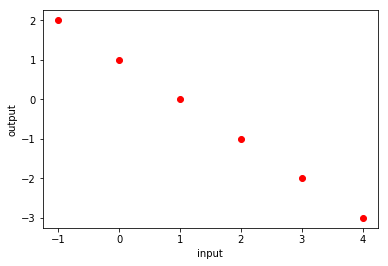

In [11]:
import matplotlib.pyplot as plt

plt.xlabel('input')
plt.ylabel('output')

plt.plot(input, output, 'ro')

### relation between input and output is linear

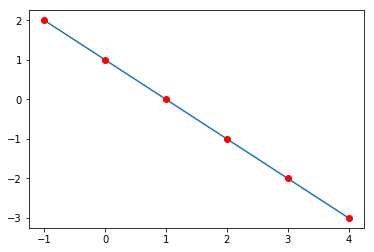

In [12]:
plt.plot(input, output)
plt.plot(input, output, 'ro')

## Defining the model to train

untrained single unit (neuron) also outputs a line from same input, although another one 

### The Artificial Neuron: Foundation of Deep Neural Networks (simplified, more later)

* a neuron takes a number of numerical inputs
* multiplies each with a weight, sums up all weighted input and  
* adds bias (constant) to that sum
* from this it creates a single numerical output
* for one input (one dimension) this would be a description of a line
* for more dimensions this describes a hyper plane that can serve as a decision boundary
* this is typically expressed as a matrix multplication plus an addition


<img src='https://djcordhose.github.io/ai/img/insurance/neuron211.jpg'>

### This can be expressed using a matrix multiplication

In [13]:
w = tf.constant([[1.5], [-2], [1]], dtype='float32')
x = tf.constant([[10, 6, 8]], dtype='float32')
b = tf.constant([6], dtype='float32')

y = tf.matmul(x, w) + b
print(y)

tf.Tensor([[17.]], shape=(1, 1), dtype=float32)


### Defining a layer with a random number of neurons and inputs

In [0]:
from tensorflow.keras.layers import Layer

class LinearLayer(Layer):
  """y = w.x + b"""

  def __init__(self, units=1, input_dim=1):
      super(LinearLayer, self).__init__()
      w_init = tf.random_normal_initializer(stddev=2)
      self.w = tf.Variable(
          initial_value = w_init(shape=(input_dim, units), dtype='float32'),
          trainable=True)
      b_init = tf.zeros_initializer()
      self.b = tf.Variable(
          initial_value = b_init(shape=(units,), dtype='float32'),
          trainable=True)

  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b
    
linear_layer = LinearLayer()

### Output of a single untrained neuron

In [15]:
x = tf.constant(input, dtype=tf.float32)
y_true = tf.constant(output, dtype=tf.float32)
y_true

<tf.Tensor: id=31, shape=(6, 1), dtype=float32, numpy=
array([[ 2.],
       [ 1.],
       [ 0.],
       [-1.],
       [-2.],
       [-3.]], dtype=float32)>

In [16]:
y_pred = linear_layer(x)
y_pred

<tf.Tensor: id=36, shape=(6, 1), dtype=float32, numpy=
array([[-1.1098791],
       [ 0.       ],
       [ 1.1098791],
       [ 2.2197583],
       [ 3.3296375],
       [ 4.4395165]], dtype=float32)>

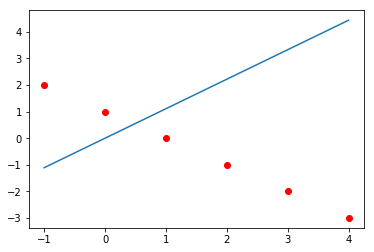

In [17]:
plt.plot(x, y_pred)
plt.plot(input, output, 'ro')

## Loss - Mean Squared Error

Loss function is the prerequisite to training. We need an objective to optimize for. We calculate the difference between what we get as output and what we would like to get.

### Mean Squared Error

$MSE = {\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}$


https://en.wikipedia.org/wiki/Mean_squared_error


In [0]:
loss_fn = tf.losses.mean_squared_error
# loss_fn = tf.losses.mean_absolute_error

In [19]:
loss = loss_fn(y_true=tf.squeeze(y_true), y_pred=tf.squeeze(y_pred))
print(loss)

tf.Tensor(17.670244, shape=(), dtype=float32)


In [20]:
tf.keras.losses.mean_squared_error == tf.losses.mean_squared_error

True

### Minimize Loss by changing parameters of neuron

Move in parameter space in the direction of a descent

<img src='https://djcordhose.github.io/ai/img/gradients.jpg'>

https://twitter.com/colindcarroll/status/1090266016259534848

### Job of the optimizer

<img src='https://djcordhose.github.io/ai/img/manning/optimizer.png' height=500>



In [21]:
# https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape

# tape will record operations for automatic differentiation
# either by making it record explicily (watch) or 
# by declaring a varible to be trainable (which we did in the layer above) 

# f(x) = x^2
# f'(x) = 2x
# x = 4
# f(4) = 16
# f'(4) = 8 (that's what we expect)
def tape_sample():
  x = tf.constant(4.0)
  with tf.GradientTape() as tape:
    tape.watch(x)
    y = x * x
  dy_dx = tape.gradient(y, x)
  print(dy_dx)
  
# just a function in order not to interfere with x on the global scope  
tape_sample()

tf.Tensor(8.0, shape=(), dtype=float32)


In [0]:
EPOCHS = 100
learning_rate = 1e-2

losses = []
weights = []
biases = []
weights_gradient = []
biases_gradient = []

linear_layer = LinearLayer()

for step in range(EPOCHS):
  # Open a GradientTape.
  with tf.GradientTape() as tape:

    # Forward pass.
    y_pred = linear_layer(x)

    # Loss value for this batch.
    loss = loss_fn(y_true=tf.squeeze(y_true), y_pred=tf.squeeze(y_pred))
    
  losses.append(loss.numpy())
  weights.append(linear_layer.w.numpy()[0][0])
  biases.append(linear_layer.b.numpy()[0])

  # Get gradients of weights wrt the loss.
  gradients = tape.gradient(loss, linear_layer.trainable_weights)
  weights_gradient.append(gradients[0].numpy()[0][0])
  biases_gradient.append(gradients[1].numpy()[0])
  
  linear_layer.w.assign_sub(learning_rate * gradients[0])
  linear_layer.b.assign_sub(learning_rate * gradients[1])

In [23]:
print(loss)

tf.Tensor(0.025972573, shape=(), dtype=float32)


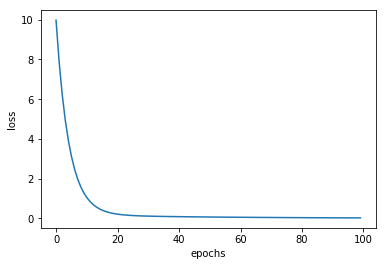

In [24]:
plt.xlabel('epochs')
plt.ylabel('loss')

# plt.yscale('log')

plt.plot(losses)

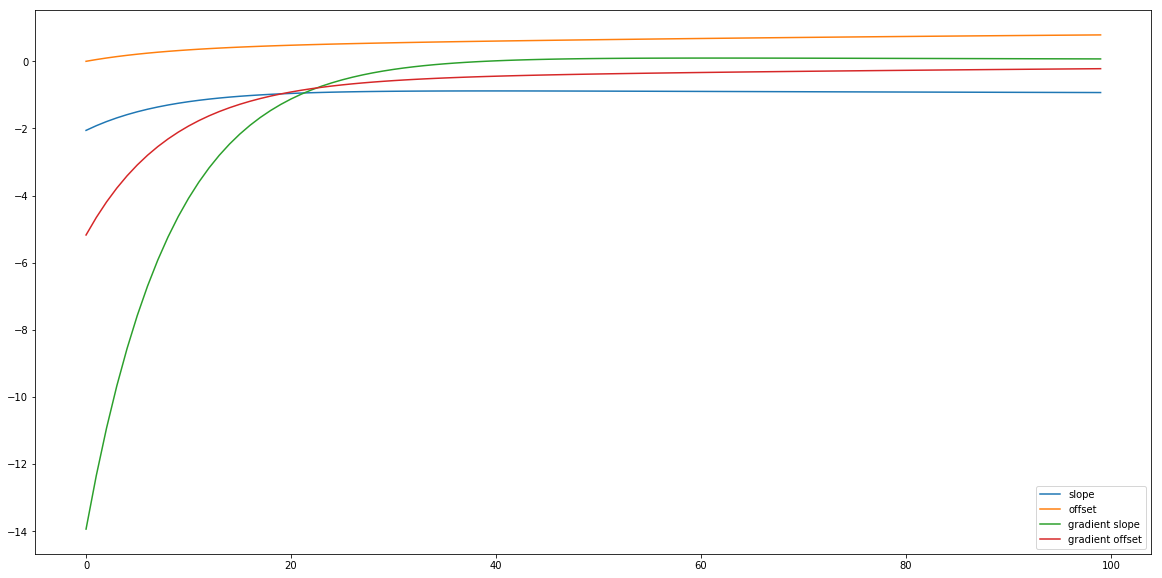

In [25]:
plt.figure(figsize=(20, 10))

plt.plot(weights)
plt.plot(biases)
plt.plot(weights_gradient)
plt.plot(biases_gradient)

plt.legend(['slope', 'offset', 'gradient slope', 'gradient offset'])

### Line drawn by neuron after training

* result after training is not perfect, but almost looks like the same line
* https://en.wikipedia.org/wiki/Linear_equation#Slope%E2%80%93intercept_form


In [26]:
y_pred = linear_layer(x)
y_pred

<tf.Tensor: id=6126, shape=(6, 1), dtype=float32, numpy=
array([[ 1.7205775 ],
       [ 0.78871745],
       [-0.14314258],
       [-1.0750027 ],
       [-2.0068626 ],
       [-2.9387226 ]], dtype=float32)>

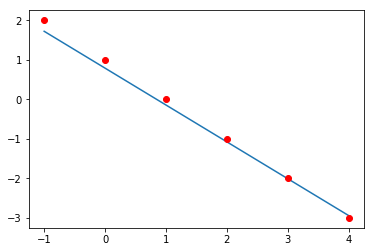

In [27]:
plt.plot(x, y_pred)
plt.plot(input, output, 'ro')

In [28]:
# single neuron and single input: one weight and one bias
# slope m ~ -1
# y-axis offset y0 ~ 1
# https://en.wikipedia.org/wiki/Linear_equation#Slope%E2%80%93intercept_form

linear_layer.trainable_weights

[<tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[-0.93186]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.78871745], dtype=float32)>]

### Prebuilt Optimizers do this job (but a bit more efficient and sohpisticated)

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)

In [0]:
EPOCHS = 500

losses = []

linear_layer = LinearLayer()

for step in range(EPOCHS):
  # Open a GradientTape.
  with tf.GradientTape() as tape:

    # Forward pass.
    y_pred = linear_layer(x)

    # Loss value for this batch.
    loss = loss_fn(y_true=tf.squeeze(y_true), y_pred=tf.squeeze(y_pred))
    
  losses.append(loss)
     
  # Get gradients of weights wrt the loss.
  gradients = tape.gradient(loss, linear_layer.trainable_weights)
  
  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, linear_layer.trainable_weights))

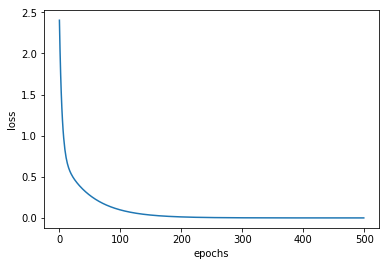

In [31]:

# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(losses)

[<tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[-0.99790365]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.9935005], dtype=float32)>]

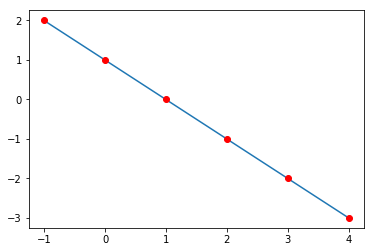

In [32]:
y_pred = linear_layer(x)
plt.plot(x, y_pred)
plt.plot(input, output, 'ro')
linear_layer.trainable_weights

## More data points, more noisy


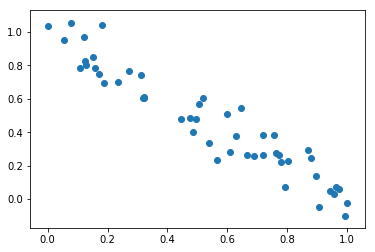

In [33]:
import numpy as np

a = -1
b = 1
n = 50

x = tf.constant(np.random.uniform(0, 1, n), dtype='float32')
y = tf.constant(a*x+b + 0.1 * np.random.normal(0, 1, n), dtype='float32')

plt.scatter(x, y)

In [0]:
x = tf.reshape(x, (n, 1))
y_true = tf.reshape(y, (n, 1))

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x7fa6306b85c0>])

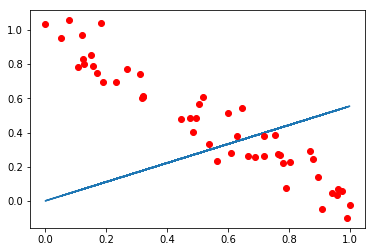

In [35]:
linear_layer = LinearLayer()

a = linear_layer.w.numpy()[0][0]
b = linear_layer.b.numpy()[0]

def plot_line(a, b, x, y_true):
  fig, ax = plt.subplots()
  y_pred = a * x + b
  
  line = ax.plot(x, y_pred)
  ax.plot(x, y_true, 'ro')
  return fig, line

plot_line(a, b, x, y_true)

In [0]:
# the problem is a little bit harder, train for a little longer
EPOCHS = 2000

losses = []
lines = []

linear_layer = LinearLayer()

for step in range(EPOCHS):
  # Open a GradientTape.
  with tf.GradientTape() as tape:

    # Forward pass.
    y_pred = linear_layer(x)

    # Loss value for this batch.
    loss = loss_fn(y_true=tf.squeeze(y_true), y_pred=tf.squeeze(y_pred))
    
  losses.append(loss)
  
  a = linear_layer.w.numpy()[0][0]
  b = linear_layer.b.numpy()[0]
  lines.append((a, b))
     
  # Get gradients of weights wrt the loss.
  gradients = tape.gradient(loss, linear_layer.trainable_weights)
  
  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, linear_layer.trainable_weights))

In [37]:
print(loss)

tf.Tensor(0.008887462, shape=(), dtype=float32)


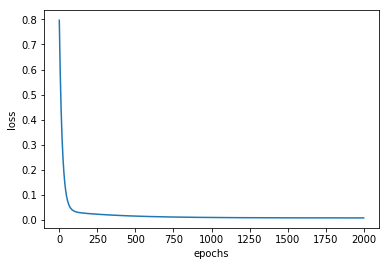

In [38]:
# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(losses)

#### Lines model draws over time

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x7fa6305486a0>])

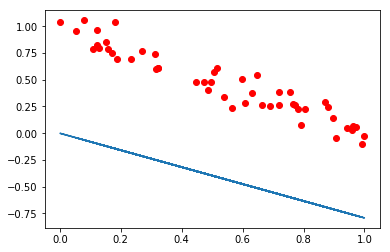

In [39]:
a, b = lines[0]

plot_line(a, b, x, y_true)

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x7fa630529208>])

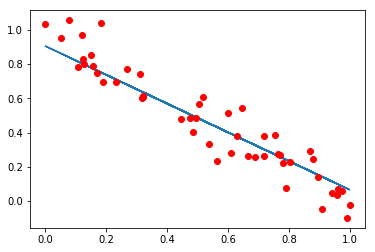

In [40]:
a, b = lines[1000]

plot_line(a, b, x, y_true)

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x7fa630487438>])

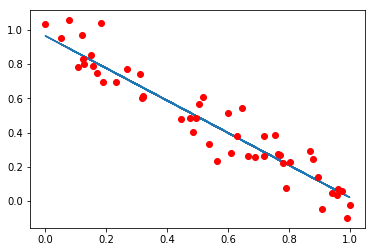

In [41]:
a, b = lines[1999]

plot_line(a, b, x, y_true)

## Understandinging the effect of the so called activation functions

Typically, the output of a neuron is transformed using an activation function which compresses the output to a value between 0 and 1 (sigmoid), or between -1 and 1 (tanh) or sets all negative values to zero (relu).

<img src='https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/img/neuron.jpg'>

### Typical Activation Functions

<img src='https://djcordhose.github.io/ai/img/activation-functions.jpg'>


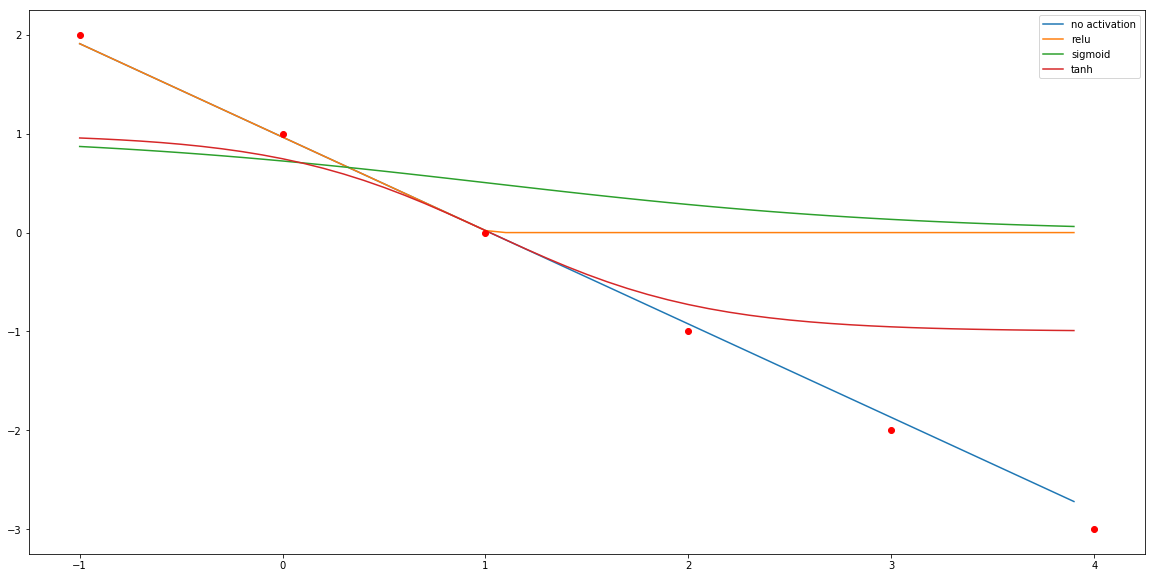

In [42]:
import numpy as np

x = tf.reshape(tf.constant(np.arange(-1, 4, 0.1), dtype='float32'), (50, 1))
y_pred = linear_layer(x)

plt.figure(figsize=(20, 10))

plt.plot(x, y_pred)

y_pred_relu = tf.nn.relu(y_pred)
plt.plot(x, y_pred_relu)

y_pred_sigmoid = tf.nn.sigmoid(y_pred)
plt.plot(x, y_pred_sigmoid)

y_pred_tanh = tf.nn.tanh(y_pred)
plt.plot(x, y_pred_tanh)

plt.plot(input, output, 'ro')

plt.legend(['no activation', 'relu', 'sigmoid', 'tanh'])

## Logictic Regression

So far we were inferring a continous value for another, now we want to classify. Imagine we have a line that separates two categories in two dimensions.

array([1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0])

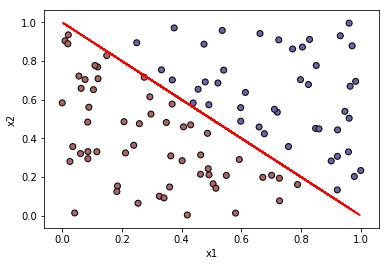

In [43]:
from matplotlib.colors import ListedColormap

a = -1
b = 1
n = 100

# all points
X = np.random.uniform(0, 1, (n, 2))

# our line
line_x = np.random.uniform(0, 1, n)
line_y = a*line_x+b
plt.plot(line_x, line_y, 'r')

# below and above line
y = X[:, 1] > a*X[:, 0]+b
y = y.astype(int)

plt.xlabel("x1")
plt.ylabel("x2")

plt.scatter(X[:,0], X[:,1], c=y, cmap=ListedColormap(['#AA6666', '#6666AA']), marker='o', edgecolors='k')
y

In [0]:
class SigmoidLayer(LinearLayer):
  """y = sigmoiud(w.x + b)"""

  def __init__(self, **kwargs):
      super(SigmoidLayer, self).__init__(**kwargs)

  def call(self, inputs):
      return tf.sigmoid(super().call(inputs))


In [0]:
x = tf.constant(X, dtype='float32')
y_true = tf.constant(y, dtype='float32')

In [0]:
EPOCHS = 1000

losses = []
accuracies = []

model = SigmoidLayer(input_dim=2)

loss_fn = tf.losses.binary_crossentropy

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)

# https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/metrics/Accuracy
m = tf.keras.metrics.Accuracy()

for step in range(EPOCHS):
  # Open a GradientTape.
  with tf.GradientTape() as tape:

    # Forward pass.
    y_pred = model(x)

    # Loss value for this batch.
    loss = loss_fn(y_true=tf.squeeze(y_true), y_pred=tf.squeeze(y_pred))

  y_pred_binary = (tf.squeeze(y_pred) > 0.5).numpy().astype(float)
  m.update_state(tf.squeeze(y_true), y_pred_binary)
  accuracy = m.result().numpy()

  losses.append(loss)
  accuracies.append(accuracy)
     
  # Get gradients of weights wrt the loss.
  gradients = tape.gradient(loss, model.trainable_weights)
  
  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

In [47]:
print(loss)

tf.Tensor(0.07674889, shape=(), dtype=float32)


In [48]:
print(accuracy)

0.95638


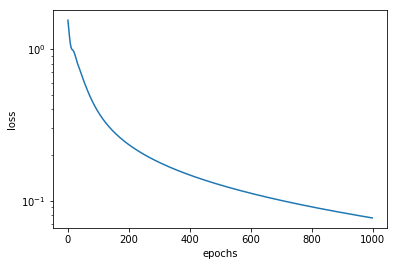

In [49]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(losses)

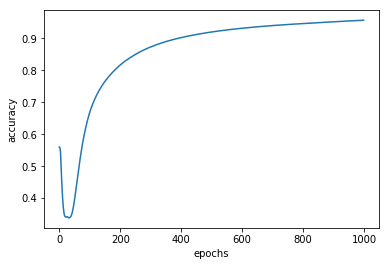

In [50]:
plt.ylabel("accuracy")
plt.xlabel("epochs")

plt.plot(accuracies)

### From single neuron to network in the TensorFlow Playground

<img src='https://djcordhose.github.io/ai/img/tf-plaground.png'>

https://playground.tensorflow.org/#activation=linear&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.98437&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false